In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.lib.stride_tricks import sliding_window_view

In [2]:

# load data
# df_map = pd.read_pickle('./60times10_CAPPI_raw').resample('1h').sum()
df_map = pd.read_pickle('./8times12_CAPPI_raw').resample('1h').sum()
df_inputs = pd.read_pickle('./2020_input_data_four_areas')
df_target = pd.read_pickle('../Drainage data/drainage_ANA_target')
df_target_2 = pd.read_pickle('../Drainage data/drainage_ING_target')

# Reshape/select data of interest
df_temp = df_inputs.iloc[:,[0]]


# Remove/reduce effect of cycle
cycle_length = 24
remove_cycle = lambda x,c : (x[c] + (np.cumsum(x[c:].values - x[:-c]))/c).shift(c)
remove_season = lambda x : x - x.rolling(24*7*4,min_periods = 1).min()

df_target = remove_season(remove_cycle(df_target,cycle_length))
df_target_2 = remove_season(remove_cycle(df_target_2,cycle_length))


# inputs = df_temp.dropna().iloc[1800:]
inputs = df_inputs.dropna().iloc[1800:]
input_2d = df_map.dropna().iloc[1800:]
target = df_target.dropna().iloc[1800:]
target_2 = df_target_2.dropna().iloc[1800:]

H,W = 8,12
C = inputs.shape[-1]

common_index = inputs.index.intersection(target.index).intersection(target_2.index).intersection(df_map.index)
inputs = inputs.loc[common_index].resample('1h').interpolate(method='linear')
input_2d = input_2d.loc[common_index].resample('1h').interpolate(method='linear')

target = target.loc[common_index].resample('1h').interpolate(method='linear')
target_2 = target_2.loc[common_index].resample('1h').interpolate(method='linear')

inputs = inputs.values
input_2d = input_2d.values.reshape(-1,H,W) 
target = np.c_[target.values,target_2.values]

In [3]:
inputs.shape

(6936, 10)

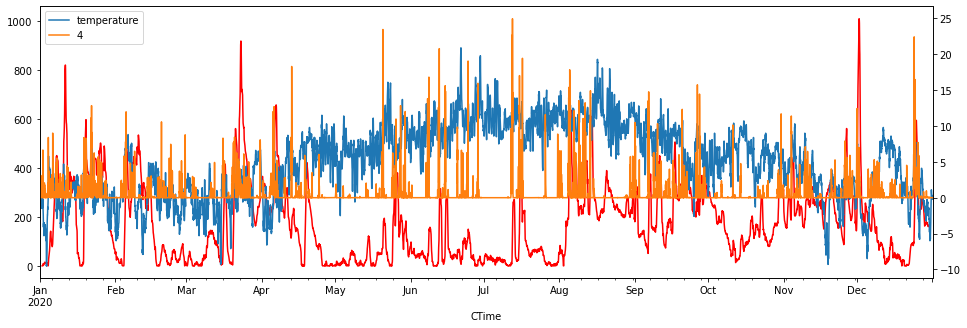

(439888.0, 440688.0)

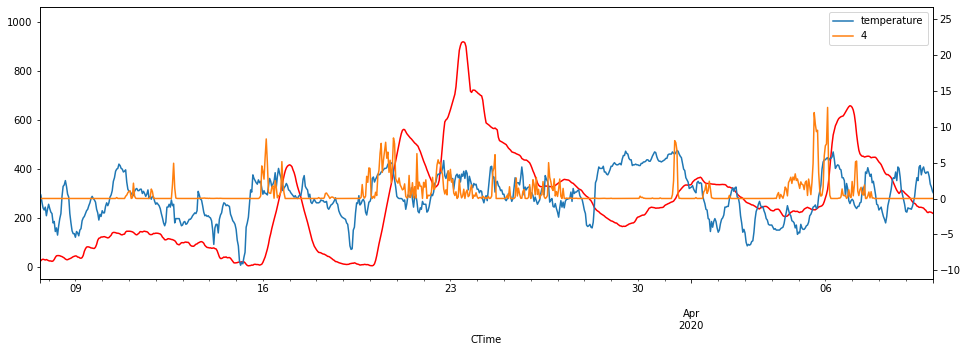

In [4]:
plt.figure(figsize=(16,5))
df_target.plot(color='red')
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
df_target.plot(color='red')
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.xlim(df_inputs.index[1600],df_inputs.index[2400])

In [40]:
np.linalg.norm([0.        , 0.11111111, 0.22222222, 0.33333334, 0.44444445])

0.6085806261445714

In [46]:


        # cast to 0 or greater
        w * tf.cast(tf.greater_equal(w, 0.), backend.floatx())
class MinMaxConstraint(tf.keras.constraints.Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        w_help = tf.math.reduce_sum(w,axis=-1)
        w_min = tf.minimum(tf.math.reduce_min(w), self.x_min)
        w_max = tf.maximum(tf.math.reduce_max(w), self.x_max)
        scale = (self.x_max - self.x_min) / (w_max - w_min)
        m = self.x_min - w_min * scale
        w = w * scale
        
        return w + m
    
class NonNegMinMaxNorm(tf.keras.constraints.Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        self.MMN = tf.keras.constraints.MinMaxNorm(x_min,x_max)
        self.non_neg = tf.keras.constraints.NonNeg()
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        w = self.MMN(w)
        w = self.non_neg(w)
        return w 
    
# MinMaxConstraint(0,1)(tf.reshape(tf.range(10,dtype='float32'),(2,5), ))

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.        , 0.11111111, 0.22222222, 0.33333334, 0.44444445],
       [0.5555556 , 0.6666667 , 0.7777778 , 0.8888889 , 1.        ]],
      dtype=float32)>

In [47]:


# Settings
sequence_size = 2*7*24 # 4 weeks in hours
n_hidden = 10
n_outputs = 2
input_shape_1 = (sequence_size,H,W,1)
# S,H,W,C = input_shape_1

# Learning layers
conv_lstm = tf.keras.layers.ConvLSTM2D(filters = n_hidden,
                                       kernel_size = 1,
                                       strides = 1,
                                       activation='relu', # only positive flow (Fron n_hidden sources)
                                       use_bias = False, # No default flow (Already removed from time series)
                                       padding='same',
                                       data_format = 'channels_last',
                                       return_sequences = True,
                                       name = 'ConvLSTM2')

# dense_melt = tf.keras.layers.Dense(1, activation = 'linear', name = 'scaling_layer')
# dense_aggregate = tf.keras.layers.Dense(n_outputs, activation = 'linear',name = 'aggregation_layer')
# dense_agg_scale = tf.keras.layers.Dense(n_outputs,
#                                         activation = 'linear',
#                                         name = 'aggregation_and_scaling_layer',
#                                         use_bias = False,
#                                         # kernel_regularizer = tf.keras.regularizers.L1(1000),
#                                         kernel_constraint = MinMaxConstraint(0.00001,1.0))

dense_spatio_temporal_sum = tf.keras.layers.Dense(n_outputs,
                                                  activation = 'linear',
                                                  name = 'sum_up_over_time',
                                                  use_bias = False,
                                                  # kernel_regularizer = tf.keras.regularizers.L1(1000),
                                                  # Add upp the flow from different locations at different times (only positive flow)
                                                  # We technically know that the combined weight for both squares should never be more than 1
                                                  # I.e. min_max_norms along the (2) n_outputs dimension
                                                  kernel_constraint = MinMaxConstraint(0.00001,1.0)
                                                  # kernel_constraint = tf.keras.constraints.MinMaxNorm(0.00001,1.0, rate = 0.99, axis = 1)
                                                  ) 



apply_to_time_slices = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
downscaler = lambda x : x #tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling2D(pool_size=(3,3),strides=(3,3)))

# dense_spatio_temporal_sum


# Reshaping layers
input_concat = tf.keras.layers.Concatenate(-1, name = 'input_concat')
lstm_output_concat = tf.keras.layers.Concatenate(-1, name = 'lstm_output_concat')
map_flatten = tf.keras.layers.Flatten(name = 'map_flattener') #tf.keras.layers.TimeDistributed()
# time_flatten = tf.keras.layers.Flatten(name = 'time_flattener')

# Model construction
input_rain = tf.keras.layers.Input(input_shape_1, name = 'input_rain')
input_other = tf.keras.layers.Input(input_shape_1[:-1] + (inputs.shape[-1],), name = 'input_heat')
input_combined = input_concat([input_rain,input_other])
lstm_output_2 = conv_lstm(input_combined)

flow_time_series = apply_to_time_slices(lstm_output_2) # gather flow from all sources
lstm_output_downscaled = downscaler(flow_time_series) # Downscale for less overfitting
flat_timeseries = map_flatten(lstm_output_downscaled)
drainage = dense_spatio_temporal_sum(flat_timeseries) # Heavily constrained adding up of all flows going into each catchment



# drainage = dense_time_sum(time_flatten(flat_timeseries))

# drainage = apply_to_time_slices(map_flatten(lstm_output_downscaled))
# drainage = dense_agg_scale(map_flatten(lstm_output_downscaled))

# outputs, h, c = conv_lstm(input_combined)
# LSTM_output = lstm_output_concat([outputs,h,c])
# surface_water_map = dense_melt(LSTM_output)
# flat_map = map_flatten(surface_water_map)
# drainage = dense_aggregate(flat_map)


model = tf.keras.Model([input_rain,input_other], drainage)


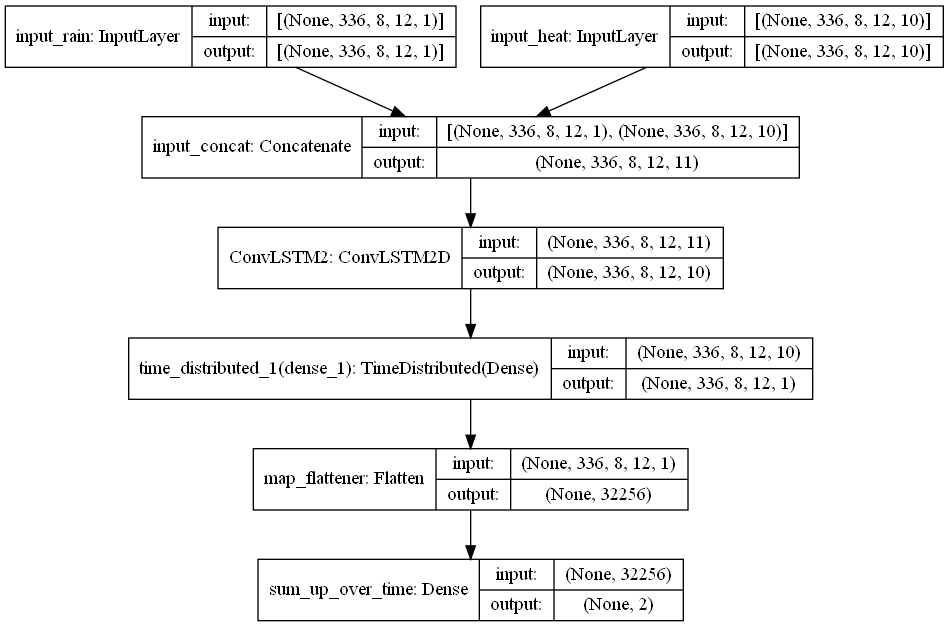

In [48]:
# Model visualization
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [49]:
# tmp = model.predict([rainfall_input_sequences[:1],temperature_input_sequences[:1]])

In [50]:
# model.trainable_weights
[(i.name, i.shape, np.product(i.shape)) for i in model.trainable_weights]

[('ConvLSTM2/kernel:0', TensorShape([1, 1, 11, 40]), 440),
 ('ConvLSTM2/recurrent_kernel:0', TensorShape([1, 1, 10, 40]), 400),
 ('time_distributed_1/kernel:0', TensorShape([10, 1]), 10),
 ('time_distributed_1/bias:0', TensorShape([1]), 1),
 ('sum_up_over_time/kernel:0', TensorShape([32256, 2]), 64512)]

In [51]:
print([(i.name, i.shape, np.product(i.shape)) for i in model.trainable_weights])
np.sum([np.product(i.shape) for i in model.trainable_weights]),

[('ConvLSTM2/kernel:0', TensorShape([1, 1, 11, 40]), 440), ('ConvLSTM2/recurrent_kernel:0', TensorShape([1, 1, 10, 40]), 400), ('time_distributed_1/kernel:0', TensorShape([10, 1]), 10), ('time_distributed_1/bias:0', TensorShape([1]), 1), ('sum_up_over_time/kernel:0', TensorShape([32256, 2]), 64512)]


(65363,)

In [52]:
output_sequences = sliding_window_view(target,(sequence_size,2)).squeeze()[:,-1]
# output_sequences = output_sequences-np.mean(output_sequences,axis = (0,1))
rainfall_input_sequences = sliding_window_view(input_2d,(sequence_size,input_2d.shape[1],input_2d.shape[2])).reshape((-1,sequence_size,H,W,1))

temperature_map_placeholder = np.full((len(inputs),H,W,C),inputs[:,np.newaxis,np.newaxis])
temperature_input_sequences = sliding_window_view(temperature_map_placeholder,(sequence_size,H,W,C)).reshape((-1,sequence_size,H,W,C))

In [53]:
output_sequences.shape,rainfall_input_sequences.shape,temperature_input_sequences.shape

((6601, 2), (6601, 336, 8, 12, 1), (6601, 336, 8, 12, 10))

In [54]:

# Model training
# optimizer = tf.optimizers.Adam(learning_rate=1e-3)
optimizer = tf.optimizers.Adam(learning_rate=1e-5, clipnorm = 0.01)
# loss_func = lambda a,b : tf.losses.MSE(a,b) + tf.losses.MAE(a,b)

model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_rain (InputLayer)         [(None, 336, 8, 12,  0                                            
__________________________________________________________________________________________________
input_heat (InputLayer)         [(None, 336, 8, 12,  0                                            
__________________________________________________________________________________________________
input_concat (Concatenate)      (None, 336, 8, 12, 1 0           input_rain[0][0]                 
                                                                 input_heat[0][0]                 
__________________________________________________________________________________________________
ConvLSTM2 (ConvLSTM2D)          (None, 336, 8, 12, 1 840         input_concat[0][0]         

In [55]:
val_ratio = 0.2
batch_size = 32
with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit([rainfall_input_sequences,temperature_input_sequences], output_sequences,
            validation_split = val_ratio,
            batch_size = batch_size,
            epochs = 50,
            verbose = 1,
            shuffle=True,
            )

Epoch 1/50
165/165 [==============================] - 94s 562ms/step - loss: 617442.8125 - mean_absolute_error: 729.1477 - mean_squared_error: 617442.8125 - val_loss: 171017.4219 - val_mean_absolute_error: 356.3461 - val_mean_squared_error: 171017.4219
Epoch 2/50
165/165 [==============================] - 91s 553ms/step - loss: 445492.7500 - mean_absolute_error: 623.7205 - mean_squared_error: 445492.7500 - val_loss: 144903.7812 - val_mean_absolute_error: 327.9070 - val_mean_squared_error: 144903.7812
Epoch 3/50
165/165 [==============================] - 84s 508ms/step - loss: 314901.4688 - mean_absolute_error: 521.8823 - mean_squared_error: 314901.4688 - val_loss: 120999.1562 - val_mean_absolute_error: 297.7573 - val_mean_squared_error: 120999.1562
Epoch 4/50
165/165 [==============================] - ETA: 0s - loss: 206923.6875 - mean_absolute_error: 417.3456 - mean_squared_error: 206923.6875

In [ ]:

# Model training
# optimizer = tf.optimizers.Adam(learning_rate=1e-3)
optimizer = tf.optimizers.Adam(learning_rate=5e-6, clipnorm = 0.01)
# loss_func = lambda a,b : tf.losses.MSE(a,b) + tf.losses.MAE(a,b)

model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE])

val_ratio = 0.2
batch_size = 16
with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit([rainfall_input_sequences,temperature_input_sequences], output_sequences,
            validation_split = val_ratio,
            batch_size = batch_size,
            epochs = 50,
            verbose = 1,
            shuffle=True,
            
            )

Epoch 1/50
330/330 [==============================] - 198s 591ms/step - loss: 79.8259 - mean_absolute_error: 79.8259 - mean_squared_error: 13617.7822 - val_loss: 126.7809 - val_mean_absolute_error: 126.7809 - val_mean_squared_error: 29714.0137
Epoch 2/50
330/330 [==============================] - 216s 654ms/step - loss: 78.2430 - mean_absolute_error: 78.2430 - mean_squared_error: 13269.1602 - val_loss: 125.8737 - val_mean_absolute_error: 125.8737 - val_mean_squared_error: 29537.4922
Epoch 3/50
330/330 [==============================] - 196s 595ms/step - loss: 78.1692 - mean_absolute_error: 78.1692 - mean_squared_error: 13269.0986 - val_loss: 126.5088 - val_mean_absolute_error: 126.5088 - val_mean_squared_error: 29580.5684
Epoch 4/50
330/330 [==============================] - 193s 586ms/step - loss: 77.7036 - mean_absolute_error: 77.7036 - mean_squared_error: 13206.8438 - val_loss: 125.9785 - val_mean_absolute_error: 125.9785 - val_mean_squared_error: 29500.5293
Epoch 5/50
330/330 [====

KeyboardInterrupt: 

In [ ]:
# snapshot_string = './TF-convLSTM models/75,8535_12677,5684_124,6675_29054,8711'
# model.save(snapshot_string)

In [18]:
model = model.load_weights(snapshot_string)

NameError: name 'snapshot_string' is not defined

In [ ]:

# Model training
# optimizer = tf.optimizers.Adam(learning_rate=1e-3)
optimizer = tf.optimizers.Adam(learning_rate=2e-6, clipnorm = 0.01)
# loss_func = lambda a,b : tf.losses.MSE(a,b) + tf.losses.MAE(a,b)

model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE])

val_ratio = 0.2
batch_size = 16
with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit([rainfall_input_sequences,temperature_input_sequences], output_sequences,
            validation_split = val_ratio,
            batch_size = batch_size,
            epochs = 50,
            verbose = 1,
            shuffle=True,
            
            )

Epoch 1/50
 54/330 [===>..........................] - ETA: 2:26 - loss: 12929.8857 - mean_absolute_error: 76.7284 - mean_squared_error: 12929.8857

KeyboardInterrupt: 

In [19]:
y_pred = model.predict([rainfall_input_sequences,temperature_input_sequences])

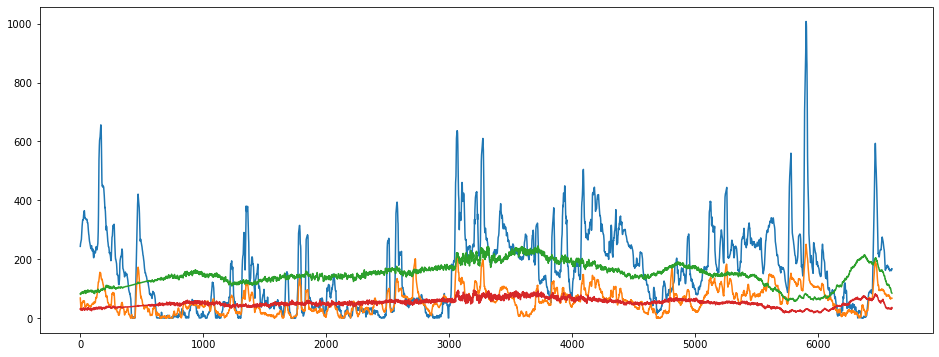

In [20]:
plt.figure(figsize=(16,6))
plt.plot(output_sequences)
plt.plot(y_pred)

In [23]:
[(i.name, i.shape) for i in model.weights]

[('ConvLSTM2/kernel:0', TensorShape([1, 1, 11, 40])),
 ('ConvLSTM2/recurrent_kernel:0', TensorShape([1, 1, 10, 40])),
 ('time_distributed/kernel:0', TensorShape([10, 1])),
 ('time_distributed/bias:0', TensorShape([1])),
 ('sum_up_over_time/kernel:0', TensorShape([32256, 2]))]

In [ ]:
sum_up_over_time

In [25]:
maps = model.weights[-1].numpy().reshape((336,H,W,2))

In [29]:
maps[:,:,:,0].sum(axis=0)

array([[-0.3608354 , -0.24181317, -0.37255248, -0.11127877, -0.2902388 ,
         0.0771763 , -0.16415325, -0.40907648, -0.24198513, -0.27317324,
        -0.0499545 , -0.2008611 ],
       [-0.20724592, -0.33354282, -0.56273806, -0.40451542, -0.52140784,
        -0.26105312, -0.29954538, -0.23318997, -0.3623125 , -0.23584981,
        -0.10249672, -0.46085474],
       [-0.09644066, -0.02800247, -0.35961664, -0.2673463 , -0.3878499 ,
        -0.2268622 , -0.27535018, -0.38130626, -0.24225144, -0.26493162,
        -0.26619807, -0.686504  ],
       [-0.42145497, -0.34095225, -0.5574114 , -0.2732031 , -0.05764955,
        -0.39741698, -0.08227688, -0.09296602, -0.33368692, -0.39471158,
        -0.08554082, -0.24173322],
       [-0.5088947 ,  0.03369492, -0.2720343 , -0.46122065, -0.39875054,
        -0.48986456,  0.03334941, -0.13285013, -0.46722493, -0.02065425,
        -0.24415964, -0.24862085],
       [-0.24236313, -0.2109373 , -0.09821609, -0.37768537, -0.09278714,
        -0.18596539, -

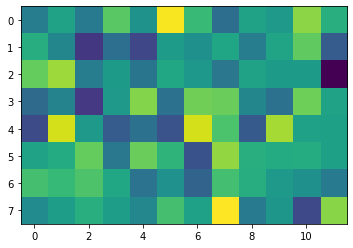

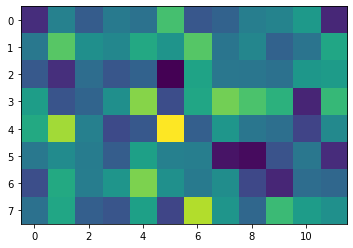

In [28]:
plt.imshow(maps[:,:,:,0].sum(axis=0));plt.show()
plt.imshow(maps[:,:,:,1].sum(axis=0));plt.show()

In [ ]:


# Start training cycle
global_step = 1

n_samples = len(training_data_loader.dataset)
n_steps = np.ceil(n_samples / training_data_loader.batch_size).astype(np.int32)

learning_rates = {#1:5e-2,
                  10: 2e-3,
                  20: 1e-3,
                  30: 5e-4,
                  35: 1e-4}

for epoch in range(1, 1000):
    if epoch in learning_rates.keys():
        for param_group in optimizer.param_groups:
            param_group["lr"] = learning_rates[epoch]
            
    # Train routine for a single epoch
    model.train()
    epoc_losses = []
    trues = []
    for i, (x, y) in enumerate(training_data_loader):
        x, y = x.permute((1,0,2)).to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        predictions, *_ = model(x)
        
        loss = loss_func(predictions.squeeze(), y.squeeze())
        # calculate gradients
        loss.backward()
        # perform parameter update
        optimizer.step()
        # lr_scheduler.step()

        # if (i + 1) % 1 == 0:
        # print(loss.item(),end='\r')
        epoc_losses.append(loss.item())
        
    model.eval()
    preds, obs = None, None
    with torch.no_grad():
        for i, (x, y) in enumerate(validation_data_loader):
            x, y = x.permute((1,0,2)).to(DEVICE), y.to(DEVICE)
            val_pred,*_ = model(x)
            val_loss = loss_func(val_pred.squeeze(),y)
            # train_error = loss = loss_func(predictions.squeeze(), y)
            print(f"Epoch {epoch} - Training loss {np.mean(epoc_losses)} - Test loss {np.mean(val_loss.item())}")

                # if cfg["tensorboard"]:
                #     writer.add_scalar('train/loss', loss.item(), global_step)

        if (global_step % 5) == 0:
            y_train_pred,*_= model(X_train.permute((1,0,2)))
            plt.figure(figsize=(12,5))
            plt.plot(y_train_pred.squeeze().cpu().detach().numpy())
            plt.plot(y_train.cpu().detach().numpy())
            plt.show()
            
            y_val_pred,*_= model(X_val.permute((1,0,2)))
            plt.figure(figsize=(12,5))
            plt.plot(y_val_pred.squeeze().cpu().detach().numpy())
            plt.plot(y_val.cpu().detach().numpy())
            plt.show()
            
            
        
    # Evaluation routine on validation set
    if (global_step % 100) == 0:
    
        weight_file =  f'model_state/model_epoch{epoch}.pt'
        torch.save(model.state_dict(), str(weight_file))
        
    global_step += 1

In [ ]:
# np.any(np.isnan(inputs))  

In [ ]:
output = model(X_train)

In [ ]:
X_train.permute()

In [ ]:
[i.shape for i in output]